In [1]:
# Header Files
import io
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import sys
import random
import warnings

import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

#from tqdm import tqdm 

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
#from keras.models import model_from_json

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)
config.log_device_placement = False  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
# Path Variables
INPUT_H5 = "road_256.h5"
MASKS_H5 = "mask_256.h5"
MODEL_H5 = "VGG16_batch_64.h5"
MODEL_FINAL = "VGG16_batch_FINAL_64.h5"

# Size Variables

IMG_SIZE = (256,256)
BATCH_SIZE = 64
EPOCHS = 50
SEED = 303

In [4]:
def getIOU(y_true, y_pred, smooth=1):
  tf.cast(y_true, tf.float32)
  tf.cast(y_pred, tf.float32)
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  return K.mean((intersection + smooth) / (union + smooth), axis=0)

In [5]:
hf1 = h5py.File(INPUT_H5, 'r')
hf2 = h5py.File(MASKS_H5,'r')

input_image=[]
input_mask=[]

input_image = list(hf1.keys())
input_image = sorted(input_image)
#print(input_image)

input_mask = list(hf2.keys())
input_mask  = sorted(input_mask)
#print(input_mask)

print(len(input_image))
print(len(input_mask))

hf1.close()
hf2.close()

6226
6226


In [6]:
val_samples = 1522
random.Random(1337).shuffle(input_image)
random.Random(1337).shuffle(input_mask)

train_input_img_paths  =  input_image[:-val_samples]
train_target_img_paths =  input_mask[:-val_samples]
val_input_img_paths    =  input_image[-val_samples:]
val_target_img_paths   =  input_mask[-val_samples:]

train_input_img_paths=sorted(train_input_img_paths)
train_target_img_paths=sorted(train_target_img_paths)
val_input_img_paths=sorted(val_input_img_paths)
val_target_img_paths=sorted(val_target_img_paths)

In [7]:
class DataLoad(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x= np.zeros((self.batch_size, 256,256,3), dtype=np.uint8)
        for j, path in enumerate(batch_input_img_paths):
            h5 = h5py.File(INPUT_H5, 'r')
            data=h5.get(path)
            data=np.array(data)
            img = Image.open(io.BytesIO(data))
            img=np.array(img)
            img=resize(img, (256,256), mode='constant',  preserve_range=True)
            x[j] = img
        
        y=np.zeros((self.batch_size, 256, 256, 1), dtype=np.bool)
        for j, path in enumerate(batch_target_img_paths):
            mask = np.zeros((256,256, 1), dtype=np.bool)
            h51=h5py.File(MASKS_H5,'r')
            data=h51.get(path)
            data=np.array(data)
            mask_=Image.open(io.BytesIO(data))
            
            mask_=np.array(mask_)
            mask_ = np.expand_dims(resize(mask_, (256,256), mode='constant',preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_) 
            y[j]=mask
            
           
        return x, y
    




train_gen = DataLoad(BATCH_SIZE, IMG_SIZE, train_input_img_paths, train_target_img_paths)
val_gen = DataLoad(BATCH_SIZE, IMG_SIZE, val_input_img_paths, val_target_img_paths)

print(len(train_gen))
print(len(val_gen))

73
23


In [8]:
IMG_WIDTH=256
IMG_HEIGHT=256
IMG_CHANNELS=3

NUM_CLASSES = 1
OPTIMIZER = 'adam'

#BUILD THE U-NET MODEL
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


In [9]:
vgg = tf.keras.applications.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(256, 256, 3),
        pooling=max
    )
print(vgg)
print(vgg.summary())

vgg.trainable = False

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [10]:
def VGG(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, nclasses=NUM_CLASSES, filters=64):
    input_layer = vgg.input
    
    # Contraction path
   

    s1 = vgg.get_layer("block1_conv2").output         # 64 filters
    s2 = vgg.get_layer("block2_conv2").output         # 128 filters
    s3 = vgg.get_layer("block3_conv3").output         # 256 filters
    s4 = vgg.get_layer("block4_conv3").output         # 512 filters

    # Bridge 
    b1 = vgg.get_layer("block5_conv3").output  # 512   
    #b1 = Dropout(0.5)(b1)
    # Expansion Path
    d1 = deconv_block(b1, s4, nfilters=filters*8)  
    #d1 = Dropout(0.3)(d1)                   
    d2 = deconv_block(d1, s3, nfilters=filters*4)   
    #d2 = Dropout(0.5)(d2)                 
    d3 = deconv_block(d2, s2, nfilters=filters*2)                     
    d4 = deconv_block(d3, s1, nfilters=filters)                      
    
    # Output
    
    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    #output_layer = Conv2D(filters=NUM_CLASSES, kernel_size=(1, 1))(d4)
    #output_layer = BatchNormalization()(output_layer)
    #output_layer = Activation('sigmoid')(output_layer)
    model = Model(inputs=input_layer, outputs=output_layer, name='VGG16')
    return model


In [11]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(MODEL_H5, verbose=1, save_best_only=True)]

In [12]:
#model = uNet()
model = VGG()
model.summary()

# Compile if any of above fresh models are used
model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy',getIOU])

#model = load_model("resnet_adam_50epochs.h5")

# Uncomment line below when fine tuning
#model.trainable = True

Model: "VGG16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
results = model.fit(train_gen,epochs=EPOCHS,batch_size=BATCH_SIZE, validation_data=val_gen,callbacks=callbacks)
print(results)

model.save(MODEL_FINAL)
print("Model Saved")

Epoch 1/50


In [24]:
print(results.history)

{'loss': [0.2855360507965088, 0.16653838753700256, 0.14408846199512482, 0.1325402557849884, 0.12564370036125183, 0.12019778043031693, 0.11455585807561874, 0.10862027108669281, 0.10328221321105957, 0.09690970182418823, 0.08993101865053177, 0.08296307176351547, 0.07737624645233154, 0.07006130367517471, 0.06428832560777664, 0.05969443917274475, 0.056074853986501694, 0.050975777208805084, 0.04843417927622795, 0.045074690133333206, 0.04208558052778244, 0.03959180414676666, 0.03828667476773262, 0.0370483361184597, 0.03618159890174866, 0.033879898488521576, 0.032385312020778656, 0.030756676569581032, 0.0303190890699625, 0.030169418081641197, 0.028884384781122208, 0.028666110709309578, 0.028012245893478394, 0.026911871507763863, 0.025542983785271645, 0.024945087730884552, 0.02453772723674774, 0.023565655574202538, 0.023108763620257378, 0.022339947521686554, 0.023393552750349045, 0.02271326258778572, 0.02314356528222561, 0.02357836812734604], 'accuracy': [0.9089884161949158, 0.9390595555305481,

In [25]:
from tensorflow.keras.models import load_model
model = load_model('VGG16_batch_FINAL_64.h5',custom_objects={'getIOU':getIOU})
print('Model Loaded')

Model Loaded


In [26]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import h5py
import matplotlib.pyplot as plt
IMG_WIDTH=256
IMG_HEIGHT=256
IMG_CHANNELS=3

In [27]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import h5py
import matplotlib.pyplot as plt

<PIL.Image.Image image mode=RGB size=256x256 at 0x7F67400A7C18>


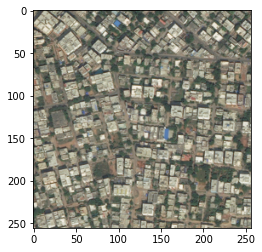

In [68]:
X_test = np.zeros((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
img=Image.open('54778_sat.jpg')
img = img.resize((256, 256))
print(img)
plt.imshow(img)
img=np.array(img)
X_test[0] = img

In [69]:
preds_test=model.predict(X_test, verbose=1)
print('Prediction:- ')
print(preds_test)
print(preds_test.shape)
print(preds_test.max(),preds_test.min())

1/1 [==============================] - 0s 1ms/step
Prediction:- 
[[[[0.10000155]
   [0.10998597]
   [0.16028012]
   ...
   [0.34236398]
   [0.3064548 ]
   [0.10406038]]

  [[0.14740257]
   [0.13355881]
   [0.27802753]
   ...
   [0.46275425]
   [0.36188278]
   [0.2829114 ]]

  [[0.08006219]
   [0.16024767]
   [0.43061298]
   ...
   [0.25405937]
   [0.19989933]
   [0.10991789]]

  ...

  [[0.00268278]
   [0.00237609]
   [0.00081414]
   ...
   [0.00476743]
   [0.01575306]
   [0.0188404 ]]

  [[0.00631297]
   [0.00396144]
   [0.00180521]
   ...
   [0.01063922]
   [0.03320043]
   [0.02934597]]

  [[0.01828122]
   [0.01116122]
   [0.01155526]
   ...
   [0.01801065]
   [0.06201669]
   [0.02672072]]]]
(1, 256, 256, 1)
1.0 6.505766e-07


In [70]:
preds_test = (preds_test > 0.5).astype(np.uint8)
print('Prediction:- ')
print(preds_test)
print(preds_test.shape)
print(preds_test.max(),preds_test.min())

Prediction:- 
[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]]
(1, 256, 256, 1)
1 0


In [71]:
mask=preds_test[0]
print('Mask:-')
print(mask)
print(mask.shape)
print(mask.max(),mask.min())

for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask[i][j] == 1:
                    mask[i][j] = 255
                else:
                    mask[i][j] = 0

Mask:-
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]
(256, 256, 1)
1 0


Output Image:- 
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
(256, 256, 3)


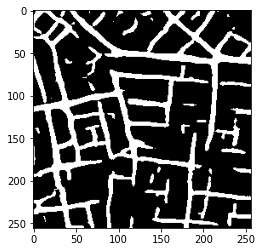

In [72]:
merged_image = cv2.merge((mask,mask,mask))
print('Output Image:- ')
print(merged_image)
print(merged_image.shape)
img=Image.fromarray(merged_image)
img.save('54778_mask.jpg')
plt.imshow(img)

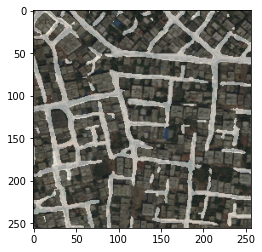

In [73]:
bg=Image.open('54778_sat.jpg')
bg=bg.resize((256,256))
overlay=Image.open('54778_mask.jpg')
bg=bg.convert('RGBA')
overlay=overlay.convert('RGBA')
new_image=Image.blend(bg,overlay,0.5)
new_image.save('merge','PNG')
plt.imshow(new_image)